In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from datetime import datetime
import numpy as np
import seaborn as sns
import sys
import sqlite3

sys.path.insert(1, "../utilities")
sys.path.insert(1, "../")

from settings import REDDIT_DIR
from helpers import convert_to_date

# from meta_analysis_rolling import read_in_comments, read_in_submissions

pd.plotting.register_matplotlib_converters()

GRAPH_DIR = "./Graphs"
FE_OR_OTHER = "FE"
STACK = False

DATA_DIR = os.path.join(REDDIT_DIR, FE_OR_OTHER)

In [2]:
import matplotlib.dates as mdates

def plot_timeline(ax, dates, names, fontsize=16):
    # Choose some nice levels
#     levels = np.tile([-3, 3, -2, 2, -1, 1],
#                     int(np.ceil(len(dates)/6)))[:len(dates)]
    
    # Choose some nice levels
    levels = np.tile([-7, -4, 7, 4],
                    int(np.ceil(len(dates)/4)))[:len(dates)]

    ax.vlines(dates, 0, levels, color="tab:red", alpha=0.75)  # The vertical stems.
    ax.plot(dates, np.zeros_like(dates), "-o",
            color="k", markerfacecolor="w", markersize=14)  # Baseline and markers on it.

    # annotate lines
    for d, l, r in zip(dates, levels, names):
        ax.annotate(r, xy=(d, l),
                    xytext=(0, np.sign(l)), textcoords="offset points",
                    horizontalalignment="center",
                    verticalalignment="bottom" if l > 0 else "top", fontsize=fontsize)

    # format xaxis with 4 month intervals
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize=fontsize)

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_ylim(-12, 12)

    ax.margins(y=0.1)
    ax.grid()

In [3]:
events = pd.read_csv("../data/fe-events.csv", delimiter=",")
events["date"] = events["date"].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
events = events.set_index("date")

In [4]:
%%time
dbs = dict()

for subdir, dirs, files in os.walk(DATA_DIR):
    for filename in files:
        filepath = os.path.join(subdir, filename)

        if filename.endswith(".db") and "sample" not in filename:
            print("Subreddit : ", filename)
            dbs[filename[:-3]] = filepath

Subreddit :  DebateFlatEarth.db
Subreddit :  flatearth.db
Subreddit :  FlatEarthIsReal.db
Subreddit :  flatearthsociety.db
Subreddit :  Flat_Earth.db
Subreddit :  Globeskeptic.db
Subreddit :  notaglobe.db
Subreddit :  theworldisflat.db
Wall time: 1.5 ms


In [5]:
# Assign colours
colour_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "black", "#a65628", "#f781bf"]
marker_list = ["-", "-", ":", ":", "--", "--", "-.", "-."]

colour_dict = {sub: col for sub, col in zip(dbs.keys(), colour_list)}
marker_dict = {sub: mar for sub, mar in zip(dbs.keys(), marker_list)}

# Get basic meta stats

In [6]:
%%time
basic_meta = dict()
for sub, fp in dbs.items():
    conn = sqlite3.connect(fp)
    curs = conn.cursor()
    
    res = curs.execute("""SELECT COUNT(*), COUNT( DISTINCT ( poster_name )) from comments
                            WHERE time < date('2021-01-01');
                            """).fetchone()
    num_coms = res[0]
    uni_use = res[1]
    
    res = curs.execute("""SELECT COUNT(*), MIN( time ), MAX ( time ) from submissions
                            WHERE time < date('2021-01-01');
                            """).fetchone()
    num_subs = res[0]
    sta_dat = res[1]
    end_dat = res[2]
    
    basic_meta[sub] = [num_coms, num_subs, uni_use, sta_dat, end_dat]

Wall time: 262 ms


In [7]:
basic_meta = pd.DataFrame(basic_meta, index=["Num Comments", "Num Submissions", "Unique Users", "Start Date", "End Date"]).T

In [8]:
basic_meta[["Num Comments", "Num Submissions", "Unique Users", "Start Date", "End Date"]]

,Num Comments,Num Submissions,Unique Users,Start Date,End Date
DebateFlatEarth,11224,649,0,2016/10/12 20:41:04,2020/12/29 20:30:03
flatearth,498262,44622,0,2013/01/19 21:48:30,2020/12/31 23:59:01
FlatEarthIsReal,2599,475,0,2017/07/18 05:31:35,2020/12/31 16:51:46
flatearthsociety,17989,1128,0,2012/06/09 18:45:29,2017/07/15 15:45:04
Flat_Earth,27005,2094,0,2013/05/08 17:47:37,2020/12/27 06:17:56
Globeskeptic,15171,1692,0,2020/02/26 20:57:40,2020/12/31 21:24:46
notaglobe,27883,2175,0,2018/08/25 22:40:14,2020/12/31 21:54:08
theworldisflat,31456,1659,0,2015/06/17 19:32:56,2020/10/29 14:16:48


In [9]:
basic_meta["Lifetime"] = (basic_meta["End Date"].apply(convert_to_date) - basic_meta["Start Date"].apply(convert_to_date)).apply(lambda x: x.days)

In [10]:
(basic_meta["Num Comments"] / basic_meta["Lifetime"]).sort_values(ascending=False)

flatearth           171.637
Globeskeptic        49.0971
notaglobe           32.4977
theworldisflat       16.049
Flat_Earth          9.68268
flatearthsociety    9.66631
DebateFlatEarth     7.29779
FlatEarthIsReal     2.05943
dtype: object

# Removed Stats

In [12]:
%%time
removed_meta = dict()
for sub, fp in dbs.items():
    conn = sqlite3.connect(fp)
    curs = conn.cursor()
    
    res = curs.execute("""SELECT COUNT(*) from comments
                            WHERE time < date('2021-01-01');
                            """).fetchone()
    num_coms = res[0]
    
    res = curs.execute("""SELECT COUNT(*) from submissions
                            WHERE time < date('2021-01-01');
                            """).fetchone()
    num_subs = res[0]
    
    res = curs.execute("""SELECT COUNT(*) from comments
                            WHERE time < date('2021-01-01')
                            AND body LIKE '%[removed]%';
                            """).fetchone()
    removed_coms = res[0]
    
    res = curs.execute("""SELECT COUNT(*) from submissions
                            WHERE time < date('2021-01-01')
                            AND body LIKE '%[removed]%';
                            """).fetchone()
    removed_subs = res[0]
    
    removed_meta[sub] = [f"{removed_coms} ({removed_coms / num_coms * 100:.2f}%)", 
                         f"{removed_subs} ({removed_subs / num_subs * 100:.2f}%)"]

Wall time: 579 ms


In [13]:
pd.DataFrame(removed_meta, index=["Removed Comments", "Removed Submissions"]).T

,Removed Comments,Removed Submissions
DebateFlatEarth,78 (0.69%),18 (2.77%)
flatearth,15986 (3.21%),3252 (7.29%)
FlatEarthIsReal,14 (0.54%),6 (1.26%)
flatearthsociety,445 (2.47%),108 (9.57%)
Flat_Earth,338 (1.25%),122 (5.83%)
Globeskeptic,822 (5.42%),319 (18.85%)
notaglobe,2567 (9.21%),12 (0.55%)
theworldisflat,9448 (30.04%),65 (3.92%)


# Get the posts per user

In [22]:
query = """
SELECT poster_name, COUNT ( uid ) as num_comments, MIN ( time ) as first, MAX ( time ) as last
FROM comments
GROUP BY poster_name
"""

In [28]:
%%time
user_stats = dict()
for sub, fp in dbs.items():
    conn = sqlite3.connect(fp)
    user_stats[sub] = pd.read_sql_query(query, conn, index_col="poster_name",
                                        parse_dates={"first": "%Y/%m/%d %H:%M:%S", 
                                                     "last": "%Y/%m/%d %H:%M:%S"})
    user_stats[sub] = user_stats[sub].drop(np.nan)

Wall time: 677 ms


In [39]:
%%time
comments_per_user = dict()
for sub in dbs:
    if 321327 in user_stats[sub].index:
        comments_per_user[sub] = user_stats[sub]["num_comments"].drop(321327).describe()
    else:
        comments_per_user[sub] = user_stats[sub]["num_comments"].describe()
    
comments_per_user = pd.DataFrame(comments_per_user)

Wall time: 15 ms


In [40]:
comments_per_user.T.loc[:, ["mean", "25%", "50%", "75%", "max"]]

,mean,25%,50%,75%,max
DebateFlatEarth,10.449360,1.0,2.0,6.0,699.0
flatearth,14.239760,1.0,2.0,4.0,9697.0
FlatEarthIsReal,4.886878,1.0,2.0,4.0,200.0
flatearthsociety,7.847435,1.0,2.0,5.0,993.0
Flat_Earth,6.634947,1.0,2.0,5.0,603.0
Globeskeptic,7.659416,1.0,2.0,5.0,968.0
notaglobe,4.782991,1.0,1.0,3.0,1499.0
theworldisflat,4.442976,1.0,1.0,2.0,1572.0


# User Lifetimes

In [41]:
%%time
lifetimes = dict()
for sub in dbs:
    user_stats[sub]["lifetime"] = (user_stats[sub]["last"] - user_stats[sub]["first"]).apply(lambda x: x.days + 1)
    if "AutoModerator" in user_stats[sub].index:
        lifetimes[sub] = user_stats[sub]["lifetime"].drop("AutoModerator").describe()
    else:
        lifetimes[sub] = user_stats[sub]["lifetime"].describe()
    
lifetimes = pd.DataFrame(lifetimes)

Wall time: 350 ms


In [42]:
lifetimes.T.loc[:, ["mean", "25%", "50%", "75%", "max"]]

,mean,25%,50%,75%,max
DebateFlatEarth,99.527357,1.0,1.0,43.00,1522.0
flatearth,68.499703,1.0,1.0,17.00,1942.0
FlatEarthIsReal,29.938914,1.0,1.0,5.75,1064.0
flatearthsociety,25.734843,1.0,1.0,3.00,1017.0
Flat_Earth,63.328912,1.0,1.0,12.00,1762.0
Globeskeptic,12.795864,1.0,1.0,4.00,310.0
notaglobe,26.958326,1.0,1.0,1.00,849.0
theworldisflat,27.511358,1.0,1.0,1.00,1906.0


# Submissions per user

In [46]:
query = """
SELECT poster_name, COUNT ( uid ) as num_submissions
FROM submissions
GROUP BY poster_name
"""

In [47]:
%%time
user_subs = dict()
for sub, fp in dbs.items():
    conn = sqlite3.connect(fp)
    user_subs[sub] = pd.read_sql_query(query, conn, index_col="poster_name")
    user_subs[sub] = user_subs[sub].drop(np.nan)

Wall time: 58.5 ms


In [48]:
%%time
submissions_per_user = dict()
for sub in dbs:
    submissions_per_user[sub] = user_subs[sub]["num_submissions"].describe()
    
submissions_per_user = pd.DataFrame(submissions_per_user)

Wall time: 11.5 ms


In [49]:
submissions_per_user.T.loc[:, ["mean", "25%", "50%", "75%", "max"]]

,mean,25%,50%,75%,max
DebateFlatEarth,1.821293,1.0,1.0,2.00,37.0
flatearth,2.187973,1.0,1.0,1.00,1411.0
FlatEarthIsReal,1.550847,1.0,1.0,1.00,20.0
flatearthsociety,1.437607,1.0,1.0,1.00,41.0
Flat_Earth,1.270563,1.0,1.0,1.00,20.0
Globeskeptic,2.372576,1.0,1.0,1.00,223.0
notaglobe,10.907216,1.0,1.0,3.00,838.0
theworldisflat,7.101064,1.0,1.0,2.25,230.0


# Comments over time

In [50]:
query = """
SELECT uid, time
FROM comments
WHERE time < date('2021-01-01')
AND time >= date('2013-01-01')
"""

In [51]:
%%time
comment_times = dict()
for sub, fp in dbs.items():
    conn = sqlite3.connect(fp)
    comment_times[sub] =  pd.read_sql_query(query, conn, index_col="uid",
                                            parse_dates={"time": "%Y/%m/%d %H:%M:%S"})
    comment_times[sub] = pd.DataFrame(comment_times[sub])
    comment_times[sub]["flag"] = [True] * len(comment_times[sub])

Wall time: 1.27 s


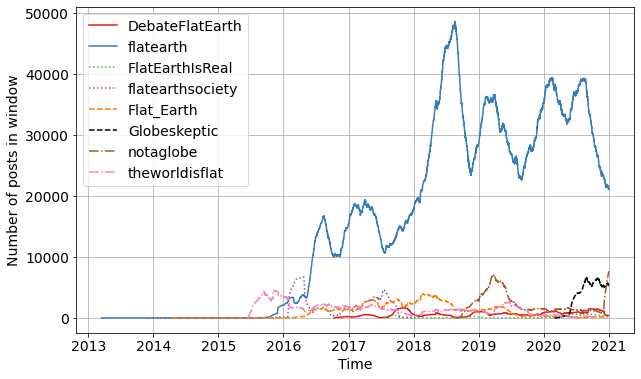

Wall time: 868 ms


In [52]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

for sub, fp in dbs.items():
    rolling_post_counts = comment_times[sub].rolling("90D", on="time").count()["flag"]
    ax.plot(comment_times[sub]["time"], rolling_post_counts.values, 
            label=sub, color=colour_dict[sub], linestyle=marker_dict[sub])
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of posts in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
ax.legend(fontsize=14)
fig.savefig(os.path.join(GRAPH_DIR, f"{FE_OR_OTHER}_comments_over_time.pdf"))
plt.show()

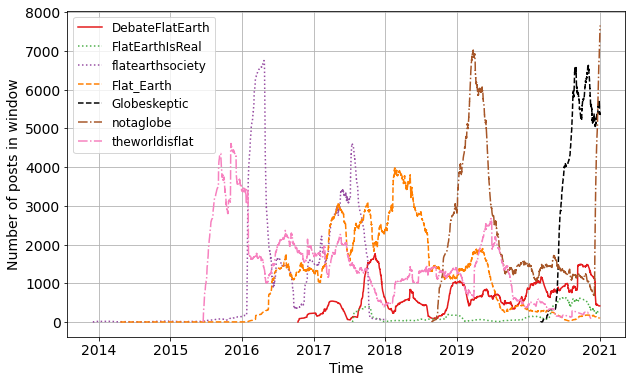

Wall time: 356 ms


In [53]:
%%time
if FE_OR_OTHER == "FE":
    fig, ax = plt.subplots(figsize=(10, 6))

    for sub, fp in dbs.items():
        if sub != "flatearth":
            rolling_post_counts = comment_times[sub].rolling("90D", on="time").count()["flag"]
            ax.plot(comment_times[sub]["time"], rolling_post_counts.values, 
                    label=sub, color=colour_dict[sub], linestyle=marker_dict[sub])

    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Number of posts in window", fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.grid()
    ax.legend(fontsize=12, loc="upper left")
    
fig.savefig(os.path.join(GRAPH_DIR, f"{FE_OR_OTHER}_no_fe_comments_over_time.pdf"))
plt.show()

# First comments over time

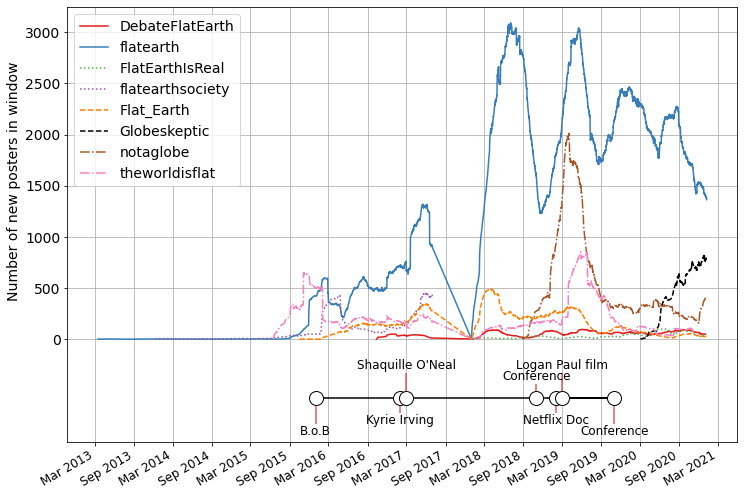

Wall time: 783 ms


In [54]:
%%time
if FE_OR_OTHER == "FE":
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1], hspace=0)
    ax = plt.subplot(gs[0])
    ax_time = plt.subplot(gs[1], sharex=ax)
    fig.subplots_adjust(hspace=0, wspace=0)
else:
    fig, ax = plt.subplots(figsize=(10, 6))

for sub, fp in dbs.items():
    curr = user_stats[sub].sort_values("first", ascending=True)
    curr["flag"] = [True] * len(curr)
    curr = curr[curr["first"] >= datetime(2013, 1, 1)]
    rolling_post_counts = curr.rolling("90D", on="first").count()["flag"]
    ax.plot(curr["first"], 
            rolling_post_counts.values, 
            label=sub, color=colour_dict[sub], linestyle=marker_dict[sub])
    del(curr)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of new posters in window", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
ax.legend(fontsize=14)

if FE_OR_OTHER == "FE":
#     for e in events.index:
#         ax.axvline(e, linestyle="--", alpha=0.5, color="gray")
#         ax_time.axvline(e, linestyle="--", alpha=0.5, color="gray")

    # Comment this chunk out if you don't want the timeline
    names = events.event
    dates = events.index
    plot_timeline(ax_time, dates, names, fontsize=12)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax_time.spines['left'].set_visible(True)
    ax_time.spines['right'].set_visible(True)

fig.savefig(os.path.join(GRAPH_DIR, f"{FE_OR_OTHER}_first_comments_over_time.pdf"))
plt.show()

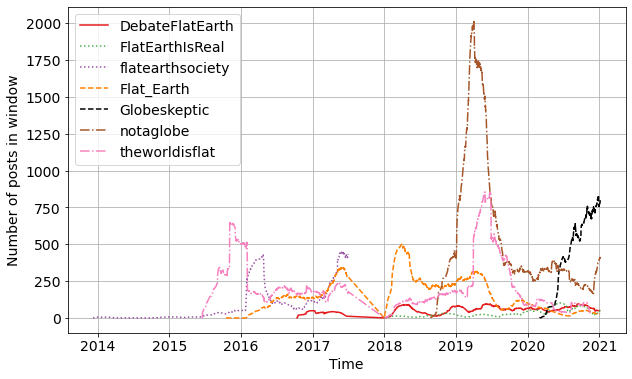

Wall time: 252 ms


In [55]:
%%time
if FE_OR_OTHER == "FE":
    fig, ax = plt.subplots(figsize=(10, 6))

    for sub, fp in dbs.items():
        if sub != "flatearth":
            curr = user_stats[sub].sort_values("first", ascending=True)
            curr["flag"] = [True] * len(curr)
            curr = curr[curr["first"] >= datetime(2013, 1, 1)]
            rolling_post_counts = curr.rolling("90D", on="first").count()["flag"]
            ax.plot(curr["first"], 
                    rolling_post_counts.values, 
                    label=sub, color=colour_dict[sub], linestyle=marker_dict[sub])
            del(curr)

    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Number of posts in window", fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.grid()
    ax.legend(fontsize=14)
    # fig.savefig(os.path.join(GRAPH_DIR, "window_posts_over_time.pdf"))
    plt.show()

# Removed comments over time

In [56]:
query = """
SELECT uid, time
FROM comments
WHERE time < date('2021-01-01')
AND time >= date('2013-01-01')
AND body LIKE '%[removed]%';
"""

In [57]:
%%time
removed = dict()
for sub, fp in dbs.items():
    conn = sqlite3.connect(fp)
    removed[sub] = pd.read_sql_query(query, conn, index_col="uid",
                                            parse_dates={"time": "%Y/%m/%d %H:%M:%S"})
    removed[sub] = pd.DataFrame(removed[sub])
    removed[sub]["flag"] = [True] * len(removed[sub])

Wall time: 433 ms


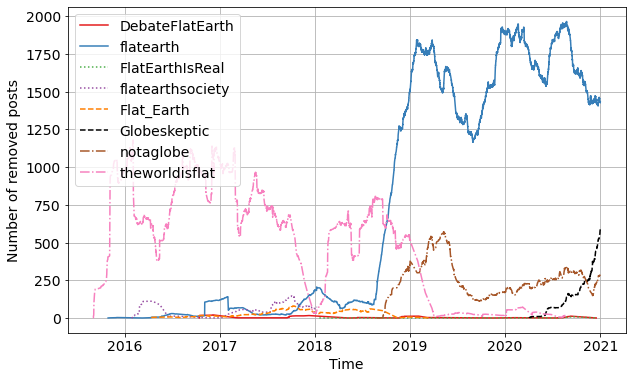

Wall time: 231 ms


In [58]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

for sub, fp in dbs.items():
    rolling_removed = removed[sub].rolling("90D", on="time").count()["flag"]
    
    ax.plot(removed[sub]["time"], rolling_removed.values, 
            label=sub, color=colour_dict[sub], linestyle=marker_dict[sub])
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of removed posts", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
ax.legend(fontsize=14, loc="upper left")
# fig.savefig(os.path.join(GRAPH_DIR, "window_posts_over_time.pdf"))
plt.show()

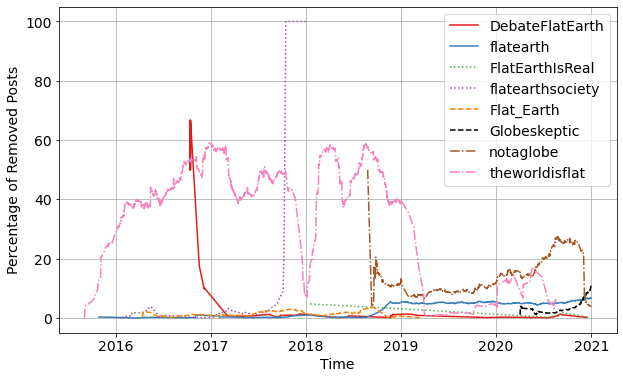

Wall time: 365 ms


In [59]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

for sub, fp in dbs.items():
    rolling_post_counts = comment_times[sub].rolling("90D", on="time").count()["flag"]
    rolling_removed = removed[sub].rolling("90D", on="time").count()["flag"]
    rolling_post_counts = rolling_post_counts.loc[rolling_removed.index]
    proportions = rolling_removed / rolling_post_counts * 100
    
    ax.plot(removed[sub]["time"], proportions.values, 
            label=sub, color=colour_dict[sub], linestyle=marker_dict[sub])
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Percentage of Removed Posts", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.grid()
ax.legend(fontsize=14, loc="upper right")
fig.savefig(os.path.join(GRAPH_DIR, f"{FE_OR_OTHER}_removed_comments_over_time.pdf"))
plt.show()